# Importation des données

In [1]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

In [2]:
nom_dossier = "100k"
#nom_dossier = "ens" #ou

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')


with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

99718

On crée index_mot et mot_index

In [3]:
phrases = ens_tweets
words = [item for sublist in phrases for item in sublist]
print(type(words))
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulary = pickle.load(f) 
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 1127347
Taille du vocabulaire : 10960


Paramètres à modifier 

On renseigne ici le numero de la simulation, cf <https://github.com/AQLT/StatApp/blob/master/Code/Parametres%20lances.md>

In [18]:
numero_simulation = 13
derniere_epoch = 10
seed = 15

In [6]:
with open('data/%s/Simulation_%i_seed%i/input_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch) , "rb") as f:
    input = pickle.load(f)
with open('data/%s/Simulation_%i_seed%i/output_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch), "rb") as f:
    output = pickle.load(f)
mat_finale = (input+output)/2
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

# 1. Similarité cosinus
Pour tester la similarité entre deux mots, on calcule la similarité cosinus entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

In [7]:
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]
print(fdist.most_common(100))

[('nickname', 89694), ('lowfrequencyword', 66423), ('de', 39312), ('le', 25066), ('est', 20926), ('je', 20215), ('les', 18382), ('c', 17566), ('j', 17252), ('la', 16791), ('à', 16484), ('pas', 16183), ('que', 12219), ('en', 12111), ('un', 11109), ('et', 10640), ('a', 10056), ('ça', 9730), ('ai', 9054), ('l', 8607), ('mais', 8261), ('il', 8238), ('pour', 7845), ('tu', 7399), ('d', 7333), ('on', 7000), ('une', 6829), ('😂', 6829), ('me', 6183), ('qui', 5452), ('ce', 5403), ('t', 5233), ('😭', 5064), ('dans', 4904), ('plus', 4861), ('sur', 4809), ('mon', 4499), ('moi', 4444), ('suis', 4422), ('qu', 4334), ('y', 4143), ('avec', 3948), ('fait', 3942), ('bien', 3884), ('vous', 3801), ('trop', 3793), ('ma', 3637), ('si', 3608), ('tout', 3286), ('m', 3206), ('elle', 3180), ('va', 3149), ('faire', 3054), ('même', 3032), ('merci', 2786), ('toi', 2757), ('ne', 2748), ('bon', 2691), ('quand', 2678), ('mdr', 2578), ('oui', 2508), ('ils', 2481), ('comme', 2456), ('non', 2446), ('n', 2438), ('se', 2343

In [8]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme","romain"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print(mot_plus_proche(mot))
        print("\n")

Pour le mot "tweet" (443 apparitions), les mots les plus proches sont : 
[('dit', 0.7407281762159872), ('par', 0.7389551521821568), ('lui', 0.6918828235874255), ('ses', 0.6912447994409128), ('prend', 0.6858992620072611), ('même', 0.6809190190018156), ('passe', 0.6725295143996586), ('temps', 0.6690630191798882), ('jour', 0.663891924405545), ('hein', 0.6625017964725866)]


Pour le mot "bonjour" (619 apparitions), les mots les plus proches sont : 
[('meme', 0.7493898882540221), ('😊', 0.7267995270624884), ('bon', 0.7188311324742304), ('demain', 0.7175019938218483), ('toi', 0.7083228037411458), ('😘', 0.6981526562311159), ('mon', 0.6700835043772805), ('remontée', 0.6591830010703776), ('baffes', 0.6542759790672673), ('toutes', 0.6538339829987037)]


Pour le mot "wesh" (117 apparitions), les mots les plus proches sont : 
[('turc', 0.7317377314133727), ('cernes', 0.715871380735775), ('🤫', 0.7118373635131072), ('story', 0.6791305777180854), ('dvd', 0.664909724419426), ('⚠', 0.6620319800778739), 

# 2. Evaluation par le "human judgement"

In [11]:
def distance_mots(word1,word2, mot_poids):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)

In [19]:
def corr_dossier(dossier = "", epoch_max = 50):
    all_cor = []
    all_p_val = []
    isdir = os.path.isdir('data/%s/Simulation_%i%s/' %(nom_dossier, numero_simulation, dossier))
    if isdir:
        for i in range(epoch_max):
            try:
                with open('data/%s/Simulation_%i%s/input_%i.file' %(nom_dossier, numero_simulation, dossier, i+1), "rb") as f:
                    input = pickle.load(f)
                with open('data/%s/Simulation_%i%s/output_%i.file' %(nom_dossier, numero_simulation, dossier, i+1), "rb") as f:
                    output = pickle.load(f)
                mat_finale = (input+output)/2
                mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids)
                df = df.dropna()
                corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                all_cor.append(corr)
                all_p_val.append(p_value)
            except OSError:
                break;     
        
    return([all_cor, all_p_val]);

def tableau_corr_hji(dossiers):
    resultats = []
    for dossier in dossiers:
        resultats.append(corr_dossier(dossier))

    max_len = max([len(x[0]) for x in resultats])
    for i in range(len(resultats)):
        if(len(resultats[i][0])<max_len):
            resultats[i][0] = resultats[i][0] +[np.nan]*(max_len - len(resultats[i][0]))
            resultats[i][1] = resultats[i][1] +[np.nan]*(max_len - len(resultats[i][1]))
    all_cor = [elem[0] for elem in resultats]
    all_cor = pd.DataFrame(np.array(all_cor),
                       columns=["Epoch %i" %int(i+1) for i in range(len(all_cor[0]))],
                      index = ["Pas de seed"] + ["Seed %i" %int(i) for i in [1,5,10,15,20,25]])
    all_p_val = [elem[1] for elem in resultats]
    all_p_val = pd.DataFrame(np.array(all_p_val),
                       columns=["Epoch %i" %int(i+1) for i in range(len(all_p_val[0]))],
                      index = ["Pas de seed"] + ["Seed %i" %int(i) for i in [1,5,10,15,20,25]])
    return([all_cor, all_p_val])
dossiers = ["", "_seed1", "_seed5", "_seed10", "_seed15", "_seed20", "_seed25"]
resultats_hji = tableau_corr_hji(dossiers)
all_cor = resultats_hji[0]
all_p_val = resultats_hji[1]
all_cor_export = round(all_cor, 3).dropna()
all_cor_export

,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,Epoch 10
Seed 1,0.181,0.165,0.236,0.253,0.302,0.121,0.099,0.143,0.060,0.104
Seed 5,0.522,0.549,0.385,0.412,0.357,0.368,0.368,0.412,0.505,0.527
Seed 10,0.110,-0.060,-0.049,-0.088,-0.066,-0.027,-0.077,-0.022,0.022,-0.005
Seed 15,0.555,0.549,0.516,0.467,0.214,0.286,0.297,0.181,0.401,0.412
Seed 20,0.582,0.555,0.505,0.473,0.522,0.489,0.484,0.484,0.484,0.566
Seed 25,-0.209,-0.176,-0.088,-0.159,-0.236,-0.203,-0.148,-0.143,-0.022,-0.088


In [20]:
##Il faut installer pandas 1.0 et tabulate
print(all_cor_export.to_markdown())

|         |   Epoch 1 |   Epoch 2 |   Epoch 3 |   Epoch 4 |   Epoch 5 |   Epoch 6 |   Epoch 7 |   Epoch 8 |   Epoch 9 |   Epoch 10 |
|:--------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|-----------:|
| Seed 1  |     0.181 |     0.165 |     0.236 |     0.253 |     0.302 |     0.121 |     0.099 |     0.143 |     0.06  |      0.104 |
| Seed 5  |     0.522 |     0.549 |     0.385 |     0.412 |     0.357 |     0.368 |     0.368 |     0.412 |     0.505 |      0.527 |
| Seed 10 |     0.11  |    -0.06  |    -0.049 |    -0.088 |    -0.066 |    -0.027 |    -0.077 |    -0.022 |     0.022 |     -0.005 |
| Seed 15 |     0.555 |     0.549 |     0.516 |     0.467 |     0.214 |     0.286 |     0.297 |     0.181 |     0.401 |      0.412 |
| Seed 20 |     0.582 |     0.555 |     0.505 |     0.473 |     0.522 |     0.489 |     0.484 |     0.484 |     0.484 |      0.566 |
| Seed 25 |    -0.209 |    -0.176 |    -0.088 |    -0.159 |    -0.236

In [ ]:
df_base = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df_base

In [112]:
distance_mots_v = np.vectorize(distance_mots)
df = df_base
df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids)
print(len(df))
df = df.dropna()
print(len(df))
df

65
13


,word1,word2,corr,corr_word2vec
0,corde,sourire,0.00,0.031334
16,côte,forêt,0.22,0.055573
20,garçon,sage,0.29,-0.305239
23,gars,sorcier,0.44,-0.047796
28,oiseau,bois,0.06,-0.060500
33,auto,voyage,0.33,0.172549
35,verre,bijou,0.56,-0.070670
38,frère,gars,2.00,0.085354
39,sage,sorcier,0.83,-0.057289
43,nourriture,fruit,2.78,0.477040


In [35]:
#On fait des tests à 5 %
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
if p_value > alpha:
    print('Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.103 / Valeur de la corrélation : 0.473


# 3. PCA

In [50]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


In [52]:
#liste = [["homme","femme", "enfant"],["chien","chat"],
#         ["vanille","chocolat"],
#    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
#    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]
liste = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

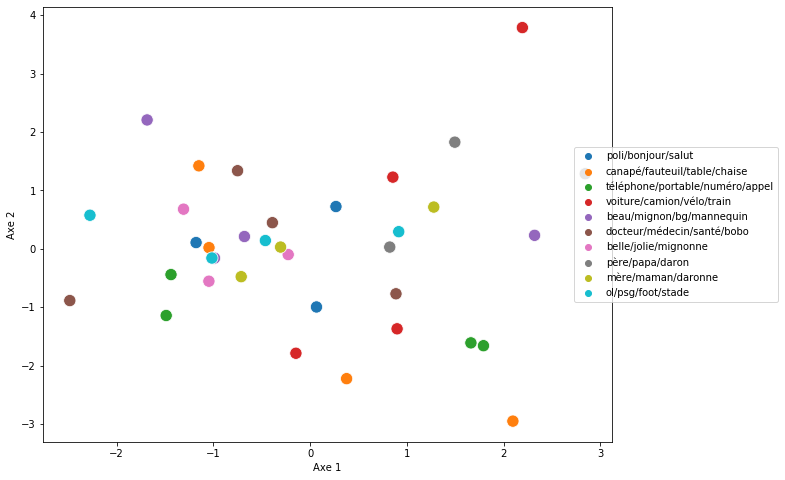

In [53]:
ACP(liste, statique = True)

In [54]:
ACP(liste, statique = False)

# 4. TSNE

In [55]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')
        

In [56]:
#liste = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
#    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
#    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
#    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
#    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
#    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
#    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
#    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
#    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
#    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
#]
liste = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

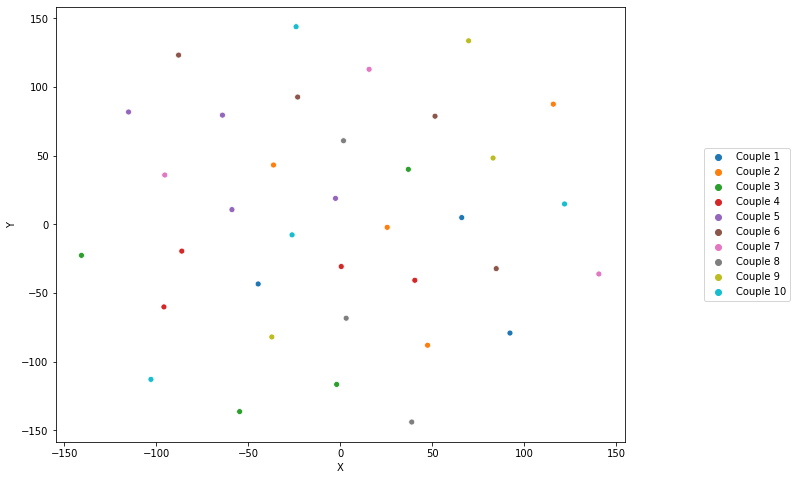

In [16]:
tsne_graph(liste, statique = True,
           nom_couples_explicite = False)

In [57]:
tsne_graph(liste, statique = False,
           nom_couples_explicite = False)